### Setup Environment:

In [1]:
from src.get_dataset import get_dataset, split_data
from src.data_loader import BRSETDataset, process_labels
# from src.RetFound import get_retfound
from src.FocalLoss import FocalLoss
from src.model import FoundationalCVModel, FoundationalCVModelWithClassifier
from sklearn.utils.class_weight import compute_class_weight

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader

from src.train import train
from src.test import test

In [2]:
# Constants:
DATASET = '/opc/davidres/retina/mbrset/data'
DOWNLOAD = False
SHAPE = (224,224)
IMAGES = os.path.join(DATASET, 'mBRSET/')
LABEL = 'final_icdr'
TEST_SIZE = 0.2
UNDERSAMPLE = False

LABELS_PATH = os.path.join(DATASET, 'labels.csv')
IMAGE_COL = 'file'

"""
Dataset Mean and Std:
NORM_MEAN = [0.5896205017400412, 0.29888971649817453, 0.1107679405196557]
NORM_STD = [0.28544273712830986, 0.15905456049750208, 0.07012281660980953]

ImageNet Mean and Std:
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]
"""

NORM_MEAN =  [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]

BACKBONE = 'dinov2_large'
MODE = 'fine_tune'
backbone_mode = 'fine_tune'

HIDDEN = [128]
num_classes = 3

BATCH_SIZE = 16
NUM_WORKERS = 4

LOSS = 'focal_loss'
OPTIMIZER = 'adam'

# Define your hyperparameters
num_epochs = 50
learning_rate = 1e-5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Read csv file:

In [3]:
df = get_dataset(DATASET, download=DOWNLOAD, info=False)
df = df[df['file'] != '985.1.jpg'] # this is missing
df.head()

loading csv file in /home/chenweiw/retina/mbrset/data/labels.csv


patient  age  sex  dm_time  insulin  insulin_time  oraltreatment_dm  \
0        1   58    1     15.0      1.0           NaN               1.0   
1        1   58    1     15.0      1.0           NaN               1.0   
2        1   58    1     15.0      1.0           NaN               1.0   
3        1   58    1     15.0      1.0           NaN               1.0   
4       10   63    0      7.0      0.0           NaN               1.0   

   systemic_hypertension  insurance  educational_level  ...  nephropathy  \
0                    1.0        0.0                3.0  ...          1.0   
1                    1.0        0.0                3.0  ...          1.0   
2                    1.0        0.0                3.0  ...          1.0   
3                    1.0        0.0                3.0  ...          1.0   
4                    1.0        0.0                2.0  ...          0.0   

   neuropathy  diabetic_foot      file  laterality  final_artifacts  \
0         0.0            0.0   1.1.jpg       right              yes   
1         0.0            0.0   1.2.jpg       right              yes   
2         0.0            0.0   1.3.jpg        left              yes   
3         0.0            0.0   1.4.jpg        left              yes   
4         0.0            0.0  10.1.jpg       right              yes   

   final_quality  final_icdr final_edema normality  
0            yes         4.0          no  abnormal  
1            yes         4.0          no  abnormal  
2            yes         4.0          no  abnormal  
3            yes         4.0          no  abnormal  
4            yes         0.0          no  abnormal  

[5 rows x 25 columns]

In [4]:

df[LABEL] = df[LABEL].apply(lambda x: 'Normal' if x == 0 else ('DR'))

Train data shape: (4130, 25)
Test data shape: (1033, 25)


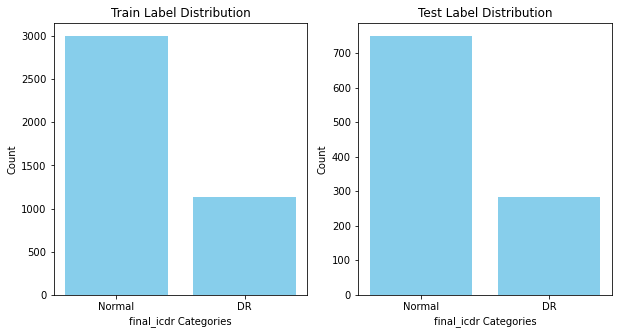

Getting validation set...


In [5]:
# Split dataset into train, test and validation:
df_train, df_test = split_data(df, LABEL, TEST_SIZE, undersample=False)
print('Getting validation set...')
df_val = df_test

### Dataloaders

In [6]:
# Train the one hot encoder on the train set and get the labels for the test and validation sets:
train_labels, mlb, train_columns = process_labels(df_train, col=LABEL)

In [7]:
# Define the target image shape

train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    # transforms.RandomCrop(SHAPE),
    transforms.ToTensor(),
    # transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    # transforms.RandomRotation(50),  # Randomly rotate the image by up to 10 degrees
])

if NORM_MEAN is not None and NORM_STD is not None:
    train_transforms.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))

test_transform = transforms.Compose([
    transforms.Resize(SHAPE),
    transforms.ToTensor(),
])

if NORM_MEAN is not None and NORM_STD is not None:
    test_transform.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))

In [8]:
# Create the custom dataset
train_dataset = BRSETDataset(
    df_train, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=train_transforms
)

test_dataset = BRSETDataset(
    df_test, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

val_dataset = BRSETDataset(
    df_val, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

In [9]:
# Create the custom dataset
train_dataset = BRSETDataset(
    df_train, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=train_transforms
)

test_dataset = BRSETDataset(
    df_test, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

val_dataset = BRSETDataset(
    df_val, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


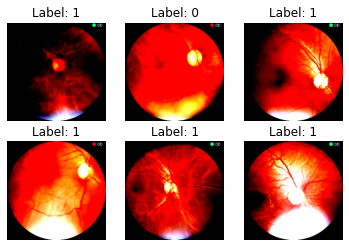

In [10]:
# Print 6 samples with their labels
# Iterate through the DataLoader and plot the images with labels

for batch in train_dataloader:

    images, labels = batch['image'], batch['labels']

    for i in range(len(images)):
        if i == 6:
            break
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # Permute to (H, W, C) from (C, H, W)
        plt.title(f"Label: {np.argmax(labels[i])}")
        plt.axis('off')
    plt.show()
    break

### Model

In [11]:
# Create a DataLoader to generate embeddings
#model = get_retfound(weights='/scratch/liyues_root/liyues/chenweiw/retina_datasets/retfound_weigths/RETFound_cfp_weights.pth', num_classes=3)
# Create a DataLoader to generate embeddings
backbone_model = FoundationalCVModel(backbone=BACKBONE, mode=MODE)
model = FoundationalCVModelWithClassifier(backbone_model, hidden=HIDDEN, num_classes=num_classes, mode=MODE, backbone_mode=backbone_mode)
model.to(device)

# Use DataParallel to parallelize the model across multiple GPUs
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, [0,1])

Using cache found in /home/chenweiw/.cache/torch/hub/facebookresearch_dinov2_main


### Training:

In [12]:
if LOSS == 'focal_loss':
    class_distribution = train_dataloader.dataset.labels.sum(axis=0)
    print(f'Class distribution: {class_distribution}')
    class_dis = np.array(class_distribution)
    class_weights =1-class_dis/np.sum(class_dis)
    weights = torch.tensor(class_weights).to(device)
    #criterion = FocalLoss()  # Focal Loss
    criterion = FocalLoss(gamma=2, alpha=weights)
else:
    # Assuming train_loader.dataset.labels is a one-hot representation
    class_indices = np.argmax(train_dataloader.dataset.labels, axis=1)

    # Compute class weights using class indices
    class_weights = compute_class_weight('balanced', classes=np.unique(class_indices), y=class_indices)
    class_weights = torch.tensor(class_weights, dtype=torch.float32)
    criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
    #criterion = nn.BCEWithLogitsLoss() # Binary Cross-Entropy Loss

if OPTIMIZER == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif OPTIMIZER == 'adamw':
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
else:
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

Class distribution: [1131 2999]


In [13]:
model = train(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=num_epochs, save=True, device=device, backbone=f'{BACKBONE}_{num_classes}class_{LABEL}')

100%|██████████| 65/65 [00:13<00:00,  4.65it/s]


Epoch 1, Train Loss: 0.0607384284742493, Val Loss: 0.06328187831319296, F1 Score: 0.2812305351215397, acc0.3165537270087125
cm[[278   5]
 [701  49]]


100%|██████████| 65/65 [00:13<00:00,  4.69it/s]


Epoch 2, Train Loss: 0.05516938819877199, Val Loss: 0.052842089648430166, F1 Score: 0.7045502652058404, acc0.7318489835430784
cm[[221  62]
 [215 535]]


100%|██████████| 65/65 [00:13<00:00,  4.73it/s]


Epoch 3, Train Loss: 0.04726428951363306, Val Loss: 0.04917609866421956, F1 Score: 0.7464860230959305, acc0.7879961277831559
cm[[198  85]
 [134 616]]


100%|██████████| 65/65 [00:13<00:00,  4.69it/s]


Epoch 4, Train Loss: 0.04078419394359625, Val Loss: 0.04668447501384295, F1 Score: 0.7877114385104864, acc0.8402710551790901
cm[[177 106]
 [ 59 691]]


100%|██████████| 65/65 [00:13<00:00,  4.90it/s]


Epoch 5, Train Loss: 0.032269039662360686, Val Loss: 0.052223173815470474, F1 Score: 0.7507239382239382, acc0.814133591481123
cm[[160 123]
 [ 69 681]]


100%|██████████| 65/65 [00:13<00:00,  4.65it/s]


Epoch 6, Train Loss: 0.026070539035895502, Val Loss: 0.05883273932223137, F1 Score: 0.7618294297584806, acc0.8044530493707648
cm[[197  86]
 [116 634]]


100%|██████████| 65/65 [00:14<00:00,  4.63it/s]


Epoch 7, Train Loss: 0.01794867422278884, Val Loss: 0.07409884279163984, F1 Score: 0.788931849616497, acc0.8489835430784124
cm[[163 120]
 [ 36 714]]


100%|██████████| 65/65 [00:13<00:00,  4.86it/s]


Epoch 8, Train Loss: 0.013676627210191267, Val Loss: 0.05405293376399921, F1 Score: 0.7621780513337124, acc0.8247821878025169
cm[[161 122]
 [ 59 691]]


100%|██████████| 65/65 [00:13<00:00,  4.68it/s]


Epoch 9, Train Loss: 0.010987207152247299, Val Loss: 0.09322505164891481, F1 Score: 0.7650913517153646, acc0.7996127783155856
cm[[215  68]
 [139 611]]


100%|██████████| 65/65 [00:13<00:00,  4.80it/s]


Epoch 10, Train Loss: 0.008775468673936854, Val Loss: 0.10017018257998503, F1 Score: 0.7843842531915926, acc0.8334946757018393
cm[[184  99]
 [ 73 677]]


100%|██████████| 65/65 [00:13<00:00,  4.68it/s]


Epoch 11, Train Loss: 0.0077838506714640225, Val Loss: 0.11868996678923185, F1 Score: 0.783207413147359, acc0.8489835430784124
cm[[154 129]
 [ 27 723]]


100%|██████████| 65/65 [00:13<00:00,  4.80it/s]


Epoch 12, Train Loss: 0.0055439168955175476, Val Loss: 0.0704296109194939, F1 Score: 0.7510391389755526, acc0.7879961277831559
cm[[208  75]
 [144 606]]


100%|██████████| 65/65 [00:13<00:00,  4.78it/s]


Epoch 13, Train Loss: 0.004009802970945009, Val Loss: 0.16794092291652654, F1 Score: 0.7900473882951982, acc0.8528557599225557
cm[[158 125]
 [ 27 723]]


100%|██████████| 65/65 [00:13<00:00,  4.86it/s]


Epoch 14, Train Loss: 0.0035281539056851853, Val Loss: 0.24664393312657643, F1 Score: 0.7608148097948857, acc0.8412391093901258
cm[[135 148]
 [ 16 734]]


100%|██████████| 65/65 [00:13<00:00,  4.65it/s]


Epoch 15, Train Loss: 0.003821614058083943, Val Loss: 0.144445642975356, F1 Score: 0.8092700148329159, acc0.8557599225556631
cm[[187  96]
 [ 53 697]]


100%|██████████| 65/65 [00:13<00:00,  4.74it/s]


Epoch 16, Train Loss: 0.012357002642289781, Val Loss: 0.06172265963485608, F1 Score: 0.7099111355183345, acc0.7386253630203291
cm[[219  64]
 [206 544]]


100%|██████████| 65/65 [00:13<00:00,  4.65it/s]


Epoch 17, Train Loss: 0.0038168750980716645, Val Loss: 0.18680129462361666, F1 Score: 0.8001372898246506, acc0.8586640851887706
cm[[164 119]
 [ 27 723]]


100%|██████████| 65/65 [00:13<00:00,  4.77it/s]


Epoch 18, Train Loss: 0.0026580263859403075, Val Loss: 0.10287057677857005, F1 Score: 0.7776970947829425, acc0.8344627299128751
cm[[170 113]
 [ 58 692]]


100%|██████████| 65/65 [00:13<00:00,  4.65it/s]


Epoch 19, Train Loss: 0.0017108797569826107, Val Loss: 0.20617889074537044, F1 Score: 0.7684982769191737, acc0.846079380445305
cm[[138 145]
 [ 14 736]]


100%|██████████| 65/65 [00:13<00:00,  4.65it/s]


Epoch 20, Train Loss: 0.0010969574997909582, Val Loss: 0.2656656247595003, F1 Score: 0.7930604068214506, acc0.8489835430784124
cm[[170 113]
 [ 43 707]]


100%|██████████| 65/65 [00:13<00:00,  4.79it/s]


Epoch 21, Train Loss: 1.1137994976953225e-05, Val Loss: 0.27005787362666944, F1 Score: 0.7900534520252831, acc0.8451113262342691
cm[[172 111]
 [ 49 701]]


100%|██████████| 65/65 [00:13<00:00,  4.81it/s]


Epoch 22, Train Loss: 5.125362453661325e-06, Val Loss: 0.27910939797797113, F1 Score: 0.7937821556002547, acc0.8470474346563408
cm[[175 108]
 [ 50 700]]
Early stopping triggered.


### Test

100%|██████████| 65/65 [00:13<00:00,  4.95it/s]


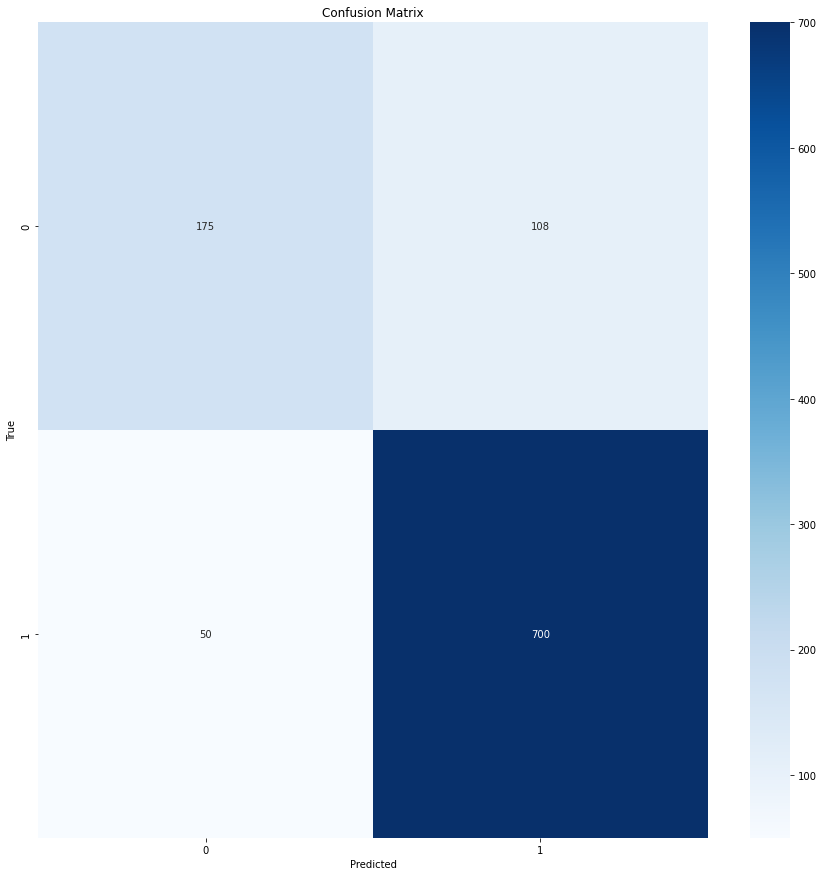

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


              precision    recall  f1-score   support

           0       0.78      0.62      0.69       283
           1       0.87      0.93      0.90       750

    accuracy                           0.85      1033
   macro avg       0.82      0.78      0.79      1033
weighted avg       0.84      0.85      0.84      1033

##################################################  Saliency Maps  ##################################################

Class 0:


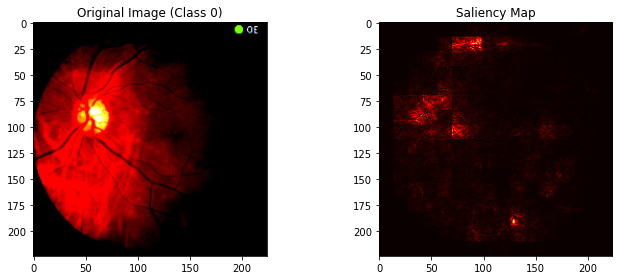

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


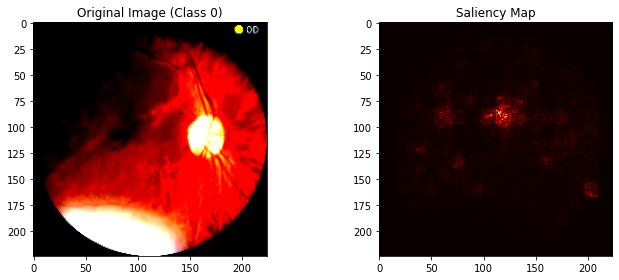

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


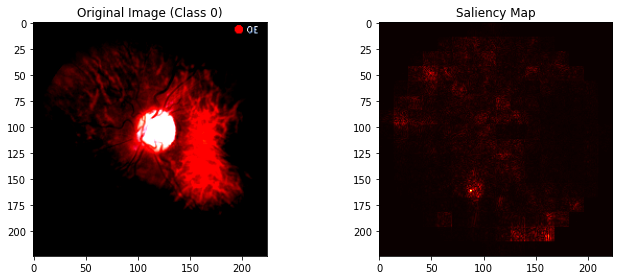

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


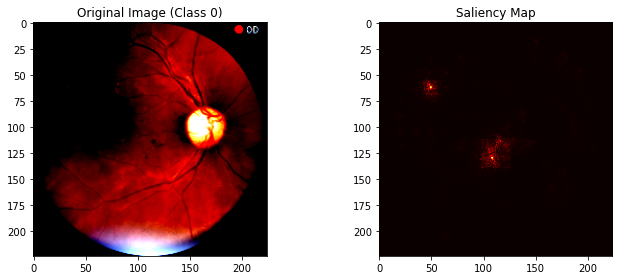

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


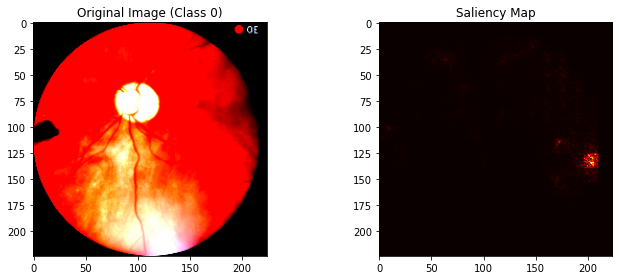

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class 1:


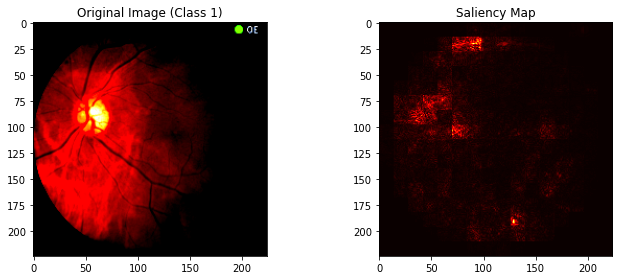

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


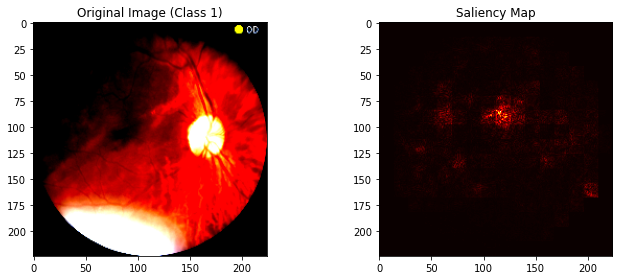

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


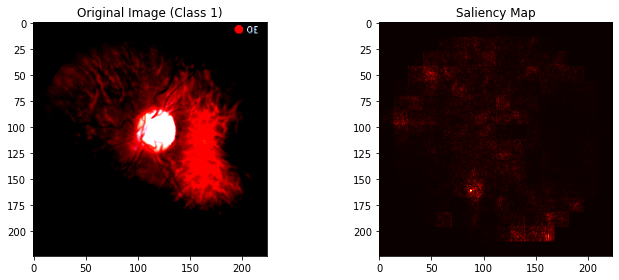

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


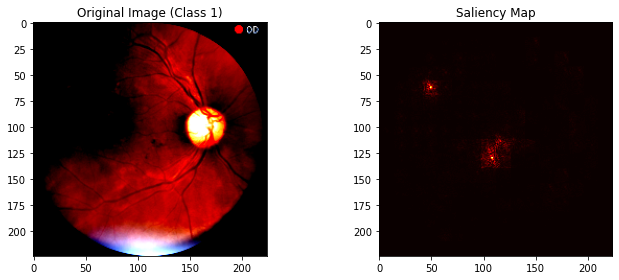

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


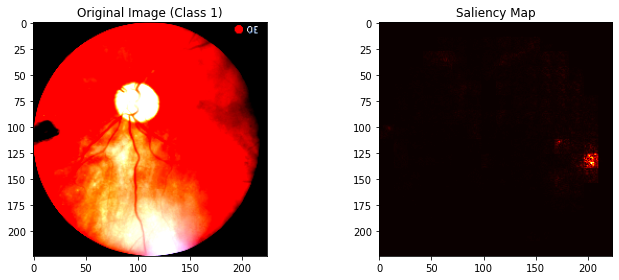

In [14]:
test(model, test_dataloader, saliency=True, device=device)

In [15]:
# Good quality images
adequate_df = df_test[df_test['final_quality'] == 'yes']

# Bad quality images
inadequate_df = df_test[df_test['final_quality'] == 'no']

adequate_dataset = BRSETDataset(
    adequate_df, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

inadequate_dataset = BRSETDataset(
    inadequate_df, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

adequate_dataloader = DataLoader(adequate_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
inadequate_dataloader = DataLoader(inadequate_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

#### Adequate image quality

100%|██████████| 73/73 [00:15<00:00,  4.64it/s]


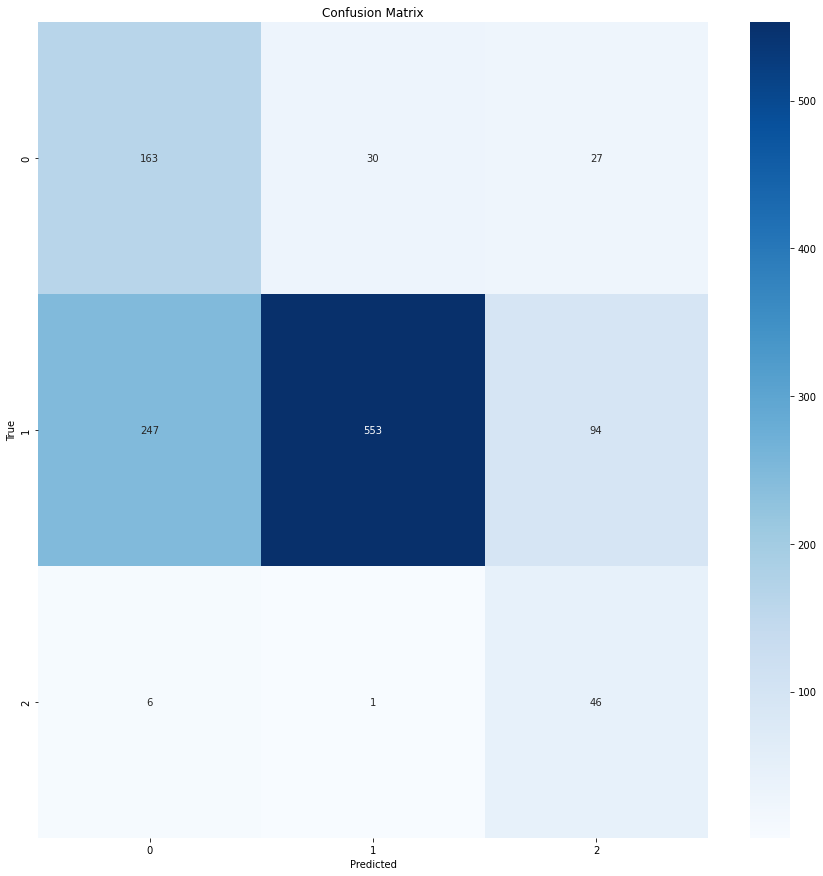

              precision    recall  f1-score   support

           0       0.39      0.74      0.51       220
           1       0.95      0.62      0.75       894
           2       0.28      0.87      0.42        53

    accuracy                           0.65      1167
   macro avg       0.54      0.74      0.56      1167
weighted avg       0.81      0.65      0.69      1167

##################################################  Saliency Maps  ##################################################

Class 0:


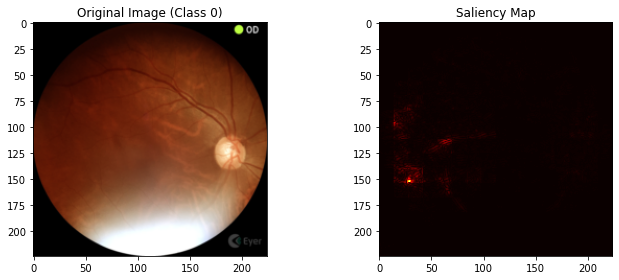

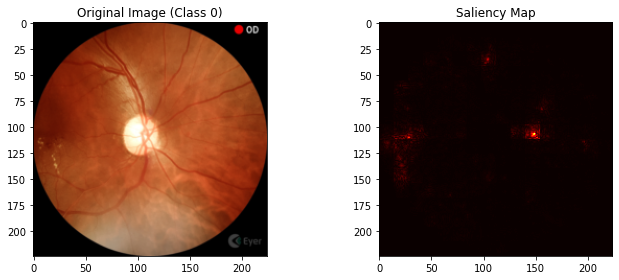

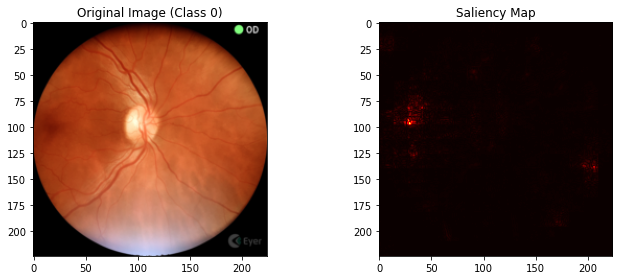

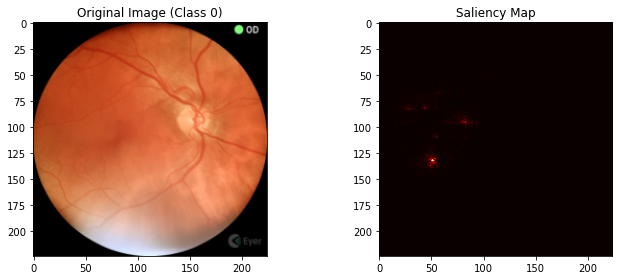

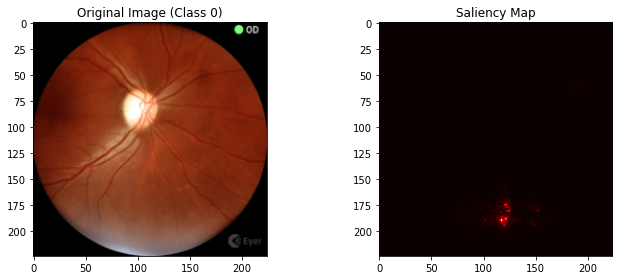

Class 1:


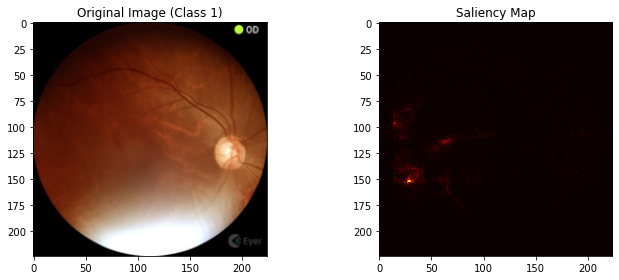

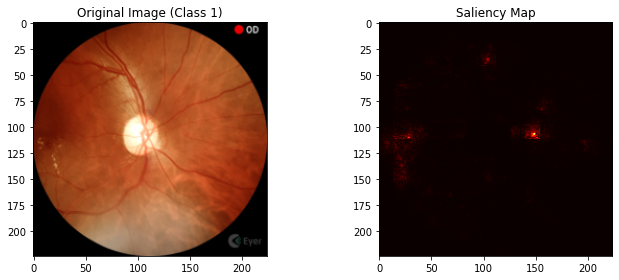

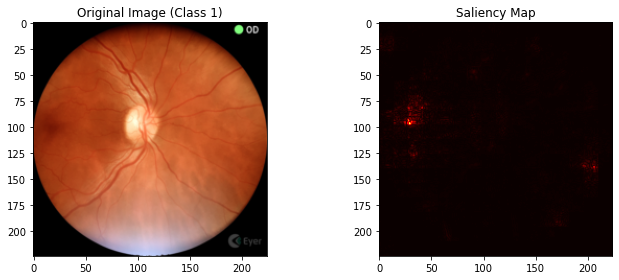

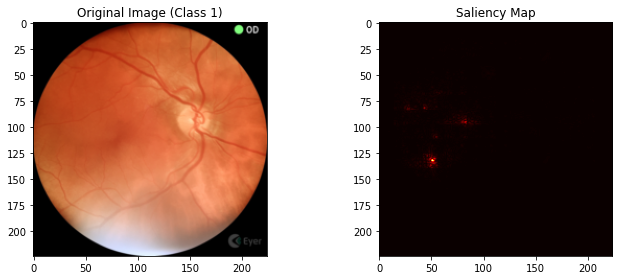

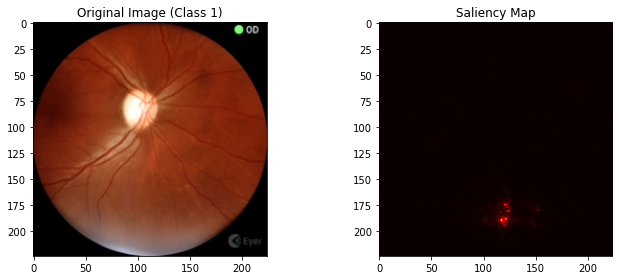

Class 2:


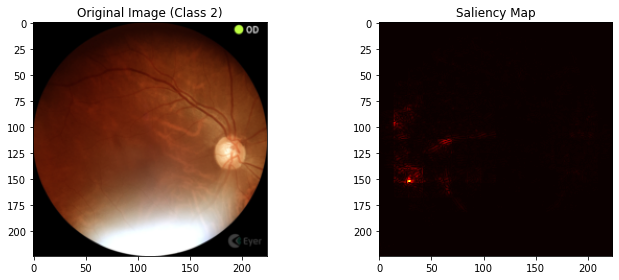

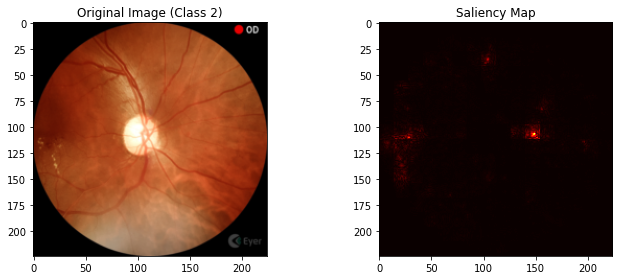

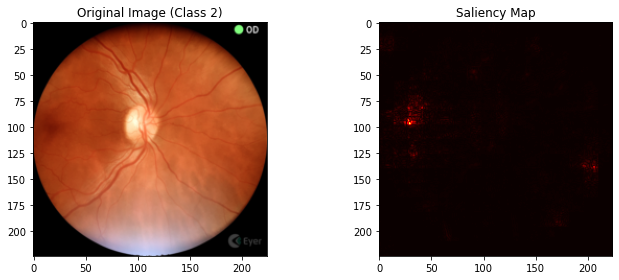

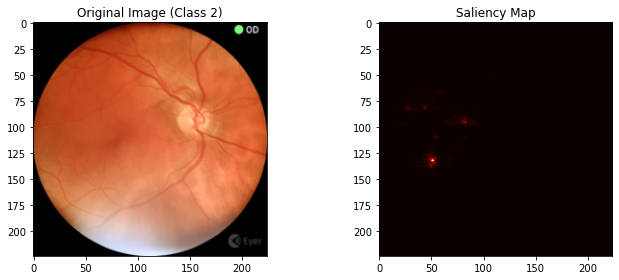

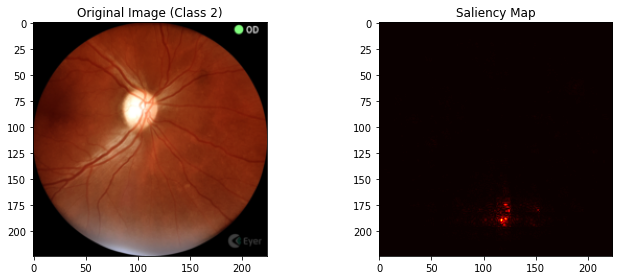

In [16]:
test(model, adequate_dataloader, saliency=True, device=device, save=True)

#### Inadequate image quality

100%|██████████| 5/5 [00:01<00:00,  3.85it/s]


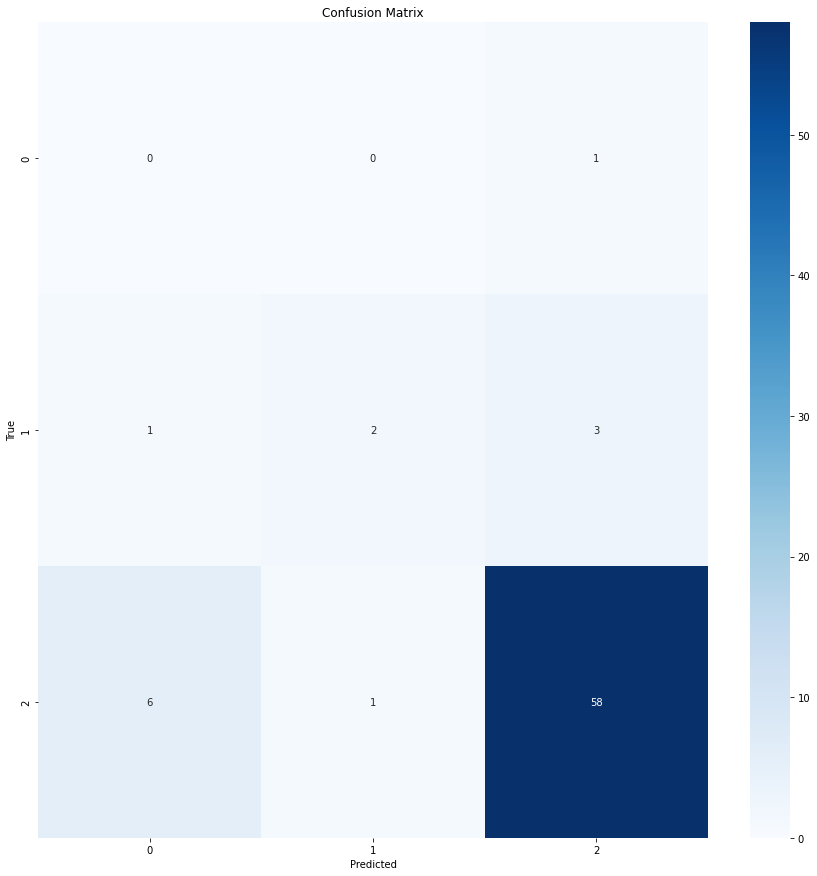

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.67      0.33      0.44         6
           2       0.94      0.89      0.91        65

    accuracy                           0.83        72
   macro avg       0.53      0.41      0.45        72
weighted avg       0.90      0.83      0.86        72

##################################################  Saliency Maps  ##################################################

Class 0:


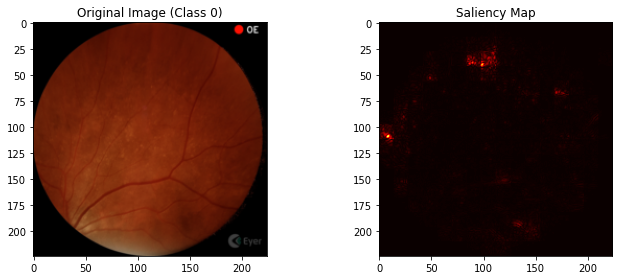

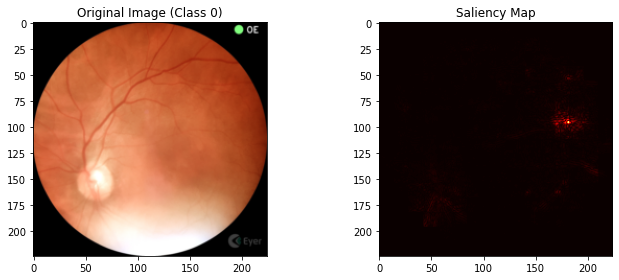

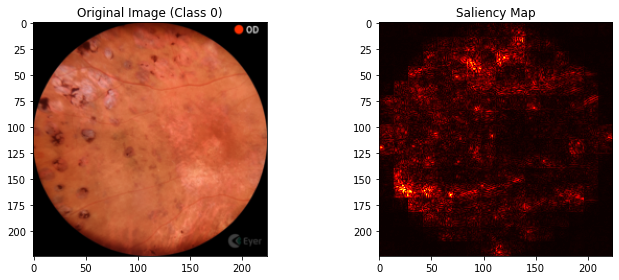

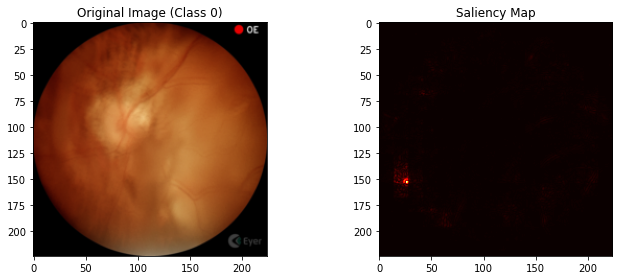

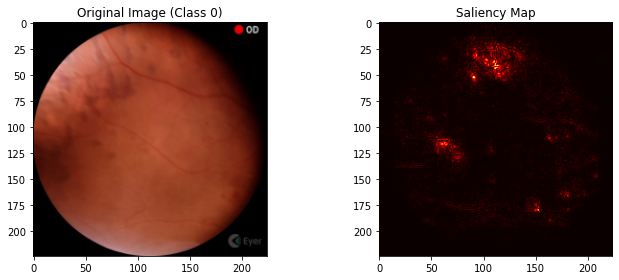

Class 1:


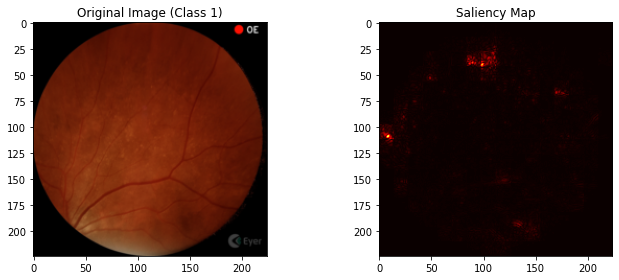

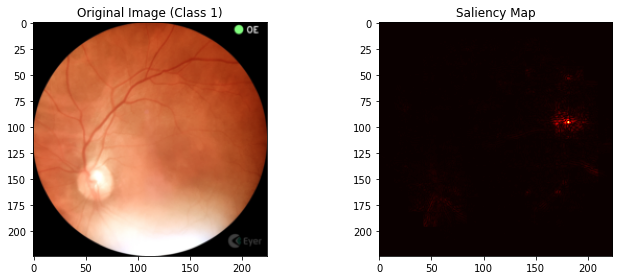

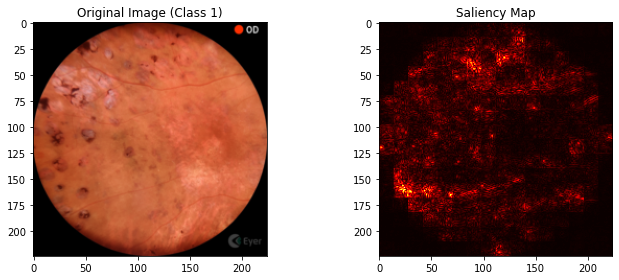

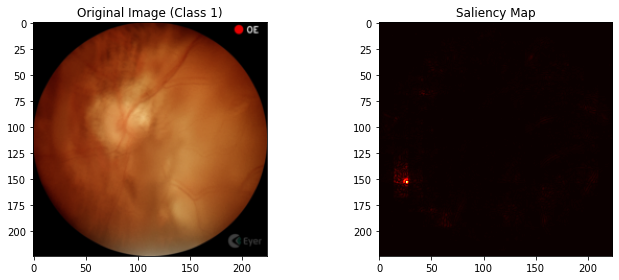

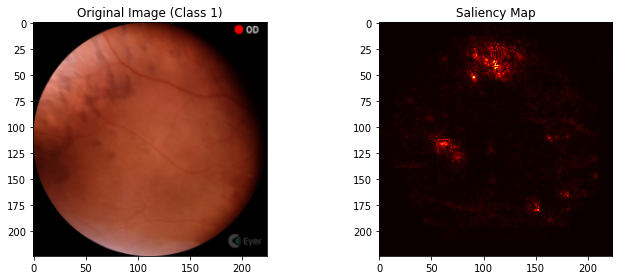

Class 2:


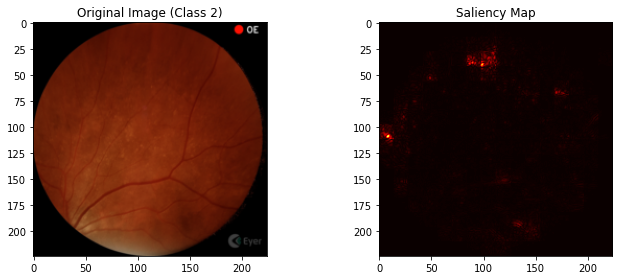

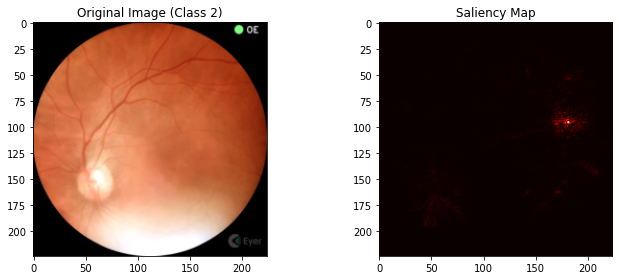

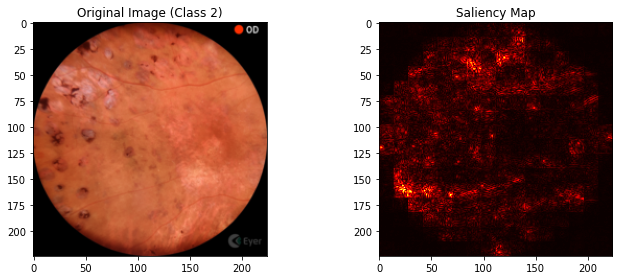

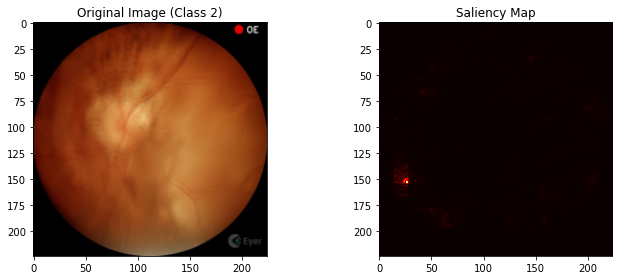

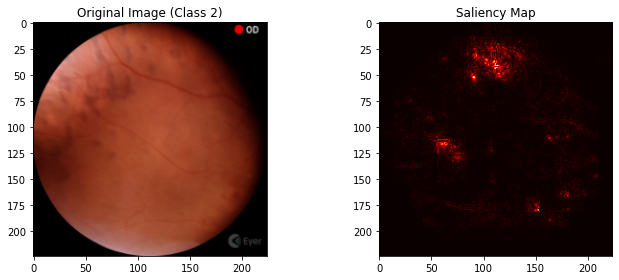

In [17]:
test(model, inadequate_dataloader, saliency=True, device=device)